In [1]:
using Clustering
using LinearAlgebra
using Plots
using Random
using SparseArrays
using ScikitLearn
@sk_import manifold : TSNE
Random.seed!(1234);  # determinism

In [2]:
# pre-compile (for class demo)
scatter(); plot(); closeall()

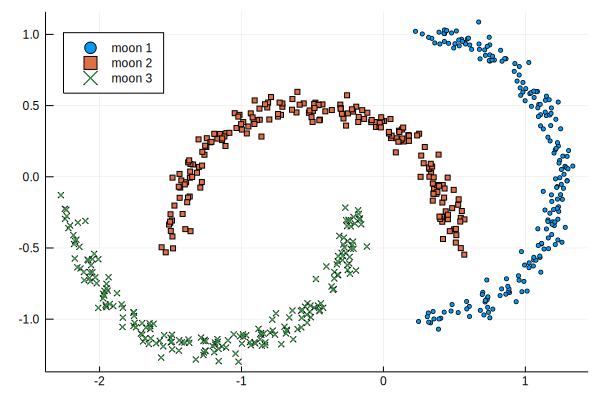

In [3]:
# Three moons
N = 200;
t = sort(rand(N) * π)
moon1 = [sin.(t) .+ 0.25 cos.(t)] .+ 0.05 * randn(N,2)
moon2 = [cos.(t) sin.(t)] .+ 0.05 * randn(N,2) .- 0.5
moon3 = [cos.(t) .- 1.2 -sin.(t) .- 0.2] .+ 0.05 * randn(N,2)
moons = [moon1; moon2; moon3]
scatter( moon1[:,1], moon1[:,2], m=:circle, ms=2, label="moon 1", legend=:topleft)
scatter!(moon2[:,1], moon2[:,2], m=:square, ms=2, label="moon 2")
scatter!(moon3[:,1], moon3[:,2], m=:X,      ms=2, label="moon 3")

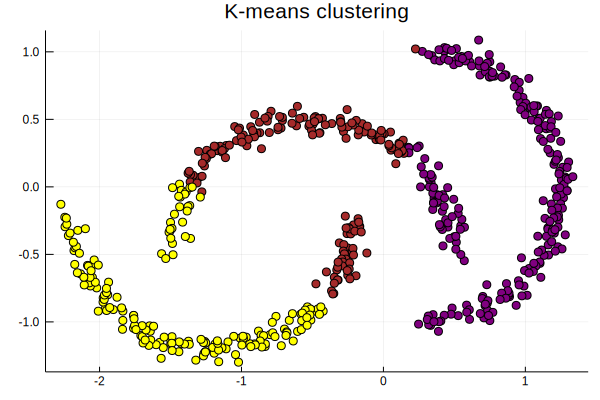

In [4]:
# k-means clustering of three moons
assignments = kmeans(moons', 3).assignments
inds1, inds2, inds3 = [findall(assignments .== i) for i = 1:3]
scatter( moons[inds1,1], moons[inds1,2], color="purple", label="")
scatter!(moons[inds2,1], moons[inds2,2], color="brown",  label="")
scatter!(moons[inds3,1], moons[inds3,2], color="yellow", label="")
title!("K-means clustering")

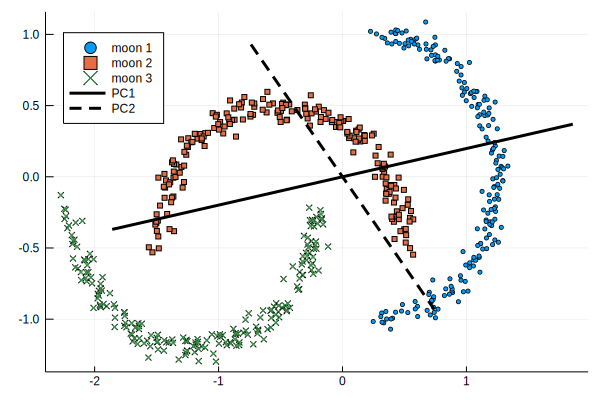

In [5]:
# PCA of three mooons
F = svd(moons)
V = F.V
dir1x, dir1y = 2 * [-V[1,1], V[1,1]], [-V[2,1], V[2,1]]
dir2x, dir2y = 2 * [-V[1,2], V[1,2]], [-V[2,2], V[2,2]]
scatter( moon1[:,1], moon1[:,2], m=:circle, ms=2, label="moon 1", legend=:topleft)
scatter!(moon2[:,1], moon2[:,2], m=:square, ms=2, label="moon 2")
scatter!(moon3[:,1], moon3[:,2], m=:X,      ms=2, label="moon 3")
plot!(dir1x, dir1y, lw=3, color="black", label="PC1")
plot!(dir2x, dir2y, lw=3, color="black", label="PC2", 
      ls=:dash, legend=:topleft)

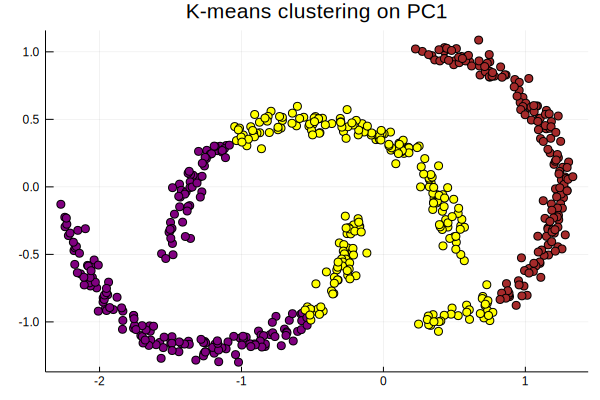

In [6]:
# PCA-based clustering of three moons
X = moons * V
PC1 = X[:,1]
assignments = kmeans(PC1', 3).assignments
inds1, inds2, inds3 = [findall(assignments .== i) for i = 1:3]
scatter( moons[inds1,1], moons[inds1,2], color="purple", label="")
scatter!(moons[inds2,1], moons[inds2,2], color="brown",  label="")
scatter!(moons[inds3,1], moons[inds3,2], color="yellow", label="")
title!("K-means clustering on PC1")

In [7]:
# Isomap on three moons
function isomap(X, Knn::Int64)
    n = size(X, 1)
    D = zeros(n, n)
    # all-pairs distances
    for i = 1:n, j = i:n
        D[i, j] = norm(vec(moons[i,:]) - vec(moons[j,:]), 2)
    end
    # k-nearest neighbors
    DX = zeros(n, n)
    for i = 1:n
        nn = sortperm(D[:, i])[2:(Knn+1)]
        DX[nn, i] = D[nn, i]
        DX[i, nn] = D[i, nn]
    end
    # shortest paths
    DG = Inf * ones(n, n)
    for i = 1:n, j = 1:n
        if DX[i, j] > 0; DG[i, j] = DX[i, j] end
    end
    DG = min.(DG, DG')
    for k = 1:n, j = 1:n, i = 1:n
        DG[i, j] = min(DG[i, j], DG[i, k] + DG[k, j])
        DG[j, i] = DG[i, j]
    end
    H = (I - ones(n, n) / n)  # centering matrix
    τG = -H * (DG .^ 2) * H / 2
    Λ, V = eigen(τG)
    return DG, Λ, V
end
DG, Λ, V = isomap(moons, 5);

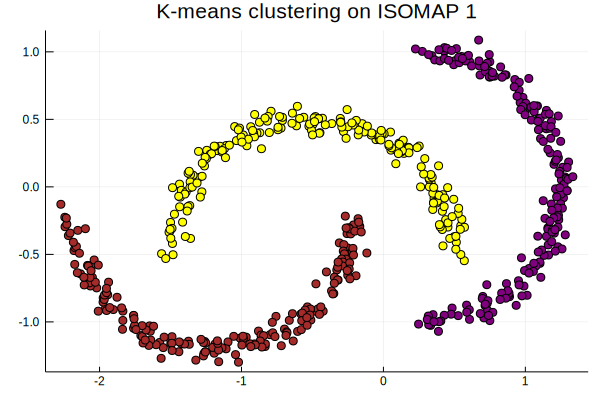

In [8]:
# Isomap-based clustering
X = V[:,1] * sqrt(Λ[1])
assignments = kmeans(X[:,1]', 3).assignments
inds1, inds2, inds3 = [findall(assignments .== i) for i = 1:3]
scatter( moons[inds1,1], moons[inds1,2], color="purple", label="")
scatter!(moons[inds2,1], moons[inds2,2], color="brown",  label="")
scatter!(moons[inds3,1], moons[inds3,2], color="yellow", label="")
title!("K-means clustering on ISOMAP 1")

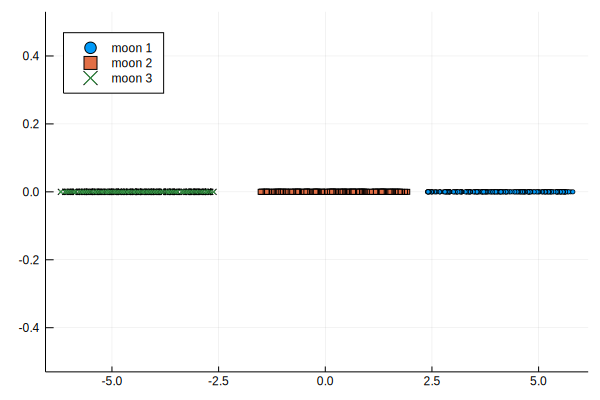

In [9]:
# ISOMAP values
inds1 = 1:N            # moon 1
inds2 = (N+1):(2*N)    # moon 2
inds3 = (2*N+1):(3*N)  # moon 3
y = zeros(N)
scatter( X[inds1,1], y, m=:circle, ms=2, label="moon 1", legend=:topleft)
scatter!(X[inds2,1], y, m=:square, ms=2, label="moon 2")
scatter!(X[inds3,1], y, m=:X,      ms=2, label="moon 3", ylim=[-0.5, 0.5])

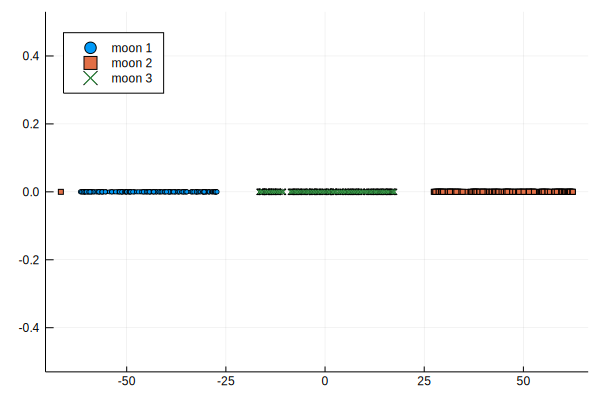

In [10]:
# t-SNE on three moons
Random.seed!(1234);
TX = TSNE(n_components=1).fit_transform(moons)
scatter( TX[inds1,1], y, m=:circle, ms=2, label="moon 1", legend=:topleft)
scatter!(TX[inds2,1], y, m=:square, ms=2, label="moon 2")
scatter!(TX[inds3,1], y, m=:X,      ms=2, label="moon 3", ylim=[-0.5, 0.5])